In [1]:

CUDA_LAUNCH_BLOCKING="1"
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
import os
import fnmatch

def recursive_glob(rootdir, suffix):
    
   
    matches = []
    for path, subdirs, files in os.walk(rootdir):
        for name in files:
         if suffix in name:
          matches.append(os.path.join(path,name))
            
                

    return matches



In [3]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF
from collections import namedtuple


class CityscapesDataset(Dataset):

    def __init__(self, root, split='train', mode='fine', augment=False):

        self.root = os.path.expanduser(root)
        self.mode = 'gtFine' if mode == 'fine' else 'gtCoarse'
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, self.mode, split)
        self.split = split
        self.augment = augment
        self.images = []
        self.targets = []
        self.mapping = {
            0: 0,  # unlabeled
            1: 0,  # ego vehicle
            2: 0,  # rect border
            3: 0,  # out of roi
            4: 0,  # static
            5: 0,  # dynamic
            6: 0,  # ground
            7: 1,  # road
            8: 0,  # sidewalk
            9: 0,  # parking
            10: 0,  # rail track
            11: 0,  # building
            12: 0,  # wall
            13: 0,  # fence
            14: 0,  # guard rail
            15: 0,  # bridge
            16: 0,  # tunnel
            17: 0,  # pole
            18: 0,  # polegroup
            19: 0,  # traffic light
            20: 0,  # traffic sign
            21: 0,  # vegetation
            22: 0,  # terrain
            23: 2,  # sky
            24: 0,  # person
            25: 0,  # rider
            26: 3,  # car
            27: 0,  # truck
            28: 0,  # bus
            29: 0,  # caravan
            30: 0,  # trailer
            31: 0,  # train
            32: 0,  # motorcycle
            33: 0,  # bicycle
            -1: 0  # licenseplate
        }
        self.mappingrgb = {
            0: (255, 0, 0),  # unlabeled
            1: (255, 0, 0),  # ego vehicle
            2: (255, 0, 0),  # rect border
            3: (255, 0, 0),  # out of roi
            4: (255, 0, 0),  # static
            5: (255, 0, 0),  # dynamic
            6: (255, 0, 0),  # ground
            7: (0, 255, 0),  # road
            8: (255, 0, 0),  # sidewalk
            9: (255, 0, 0),  # parking
            10: (255, 0, 0),  # rail track
            11: (255, 0, 0),  # building
            12: (255, 0, 0),  # wall
            13: (255, 0, 0),  # fence
            14: (255, 0, 0),  # guard rail
            15: (255, 0, 0),  # bridge
            16: (255, 0, 0),  # tunnel
            17: (255, 0, 0),  # pole
            18: (255, 0, 0),  # polegroup
            19: (255, 0, 0),  # traffic light
            20: (255, 0, 0),  # traffic sign
            21: (255, 0, 0),  # vegetation
            22: (255, 0, 0),  # terrain
            23: (0, 0, 255),  # sky
            24: (255, 0, 0),  # person
            25: (255, 0, 0),  # rider
            26: (255, 255, 0),  # car
            27: (255, 0, 0),  # truck
            28: (255, 0, 0),  # bus
            29: (255, 0, 0),  # caravan
            30: (255, 0, 0),  # trailer
            31: (255, 0, 0),  # train
            32: (255, 0, 0),  # motorcycle
            33: (255, 0, 0),  # bicycle
            -1: (255, 0, 0)  # licenseplate
        }

        # Ensure that this matches the above mapping!#!@#!@#
        # For example 4 classes, means we should map to the ids=(0,1,2,3)
        # This is used to specify how many outputs the network should product...
        self.num_classes = 4

        # =============================================
        # Check that inputs are valid
        # =============================================
        if mode not in ['fine', 'coarse']:
            raise ValueError('Invalid mode! Please use mode="fine" or mode="coarse"')
        if mode == 'fine' and split not in ['train', 'test', 'val']:
            raise ValueError('Invalid split for mode "fine"! Please use split="train", split="test" or split="val"')
        elif mode == 'coarse' and split not in ['train', 'train_extra', 'val']:
            raise ValueError('Invalid split for mode "coarse"! Please use split="train", split="train_extra" or split="val"')
        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):
            raise RuntimeError('Dataset not found or incomplete. Please make sure all required folders for the'
                               ' specified "split" and "mode" are inside the "root" directory')

        # =============================================
        # Read in the paths to all images
        # =============================================
        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))
                target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0], '{}_labelIds.png'.format(self.mode))
                # target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0], '{}_color.png'.format(self.mode))
                self.targets.append(os.path.join(target_dir, target_name))

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of images: {}\n'.format(self.__len__())
        fmt_str += '    Split: {}\n'.format(self.split)
        fmt_str += '    Mode: {}\n'.format(self.mode)
        fmt_str += '    Augment: {}\n'.format(self.augment)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        return fmt_str

    def __len__(self):
        return len(self.images)

    def mask_to_class(self, mask):
        '''
        Given the cityscapes dataset, this maps to a 0..classes numbers.
        This is because we are using a subset of all masks, so we have this "mapping" function.
        This mapping function is used to map all the standard ids into the smaller subset.
        '''
        maskimg = torch.zeros((mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in self.mapping:
            maskimg[mask == k] = self.mapping[k]
        return maskimg

    def mask_to_rgb(self, mask):
        '''
        Given the Cityscapes mask file, this converts the ids into rgb colors.
        This is needed as we are interested in a sub-set of labels, thus can't just use the
        standard color output provided by the dataset.
        '''
        rgbimg = torch.zeros((3, mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in self.mappingrgb:
            rgbimg[0][mask == k] = self.mappingrgb[k][0]
            rgbimg[1][mask == k] = self.mappingrgb[k][1]
            rgbimg[2][mask == k] = self.mappingrgb[k][2]
        return rgbimg

    def class_to_rgb(self, mask):
        '''
        This function maps the classification index ids into the rgb.
        For example after the argmax from the network, you want to find what class
        a given pixel belongs too. This does that but just changes the color
        so that we can compare it directly to the rgb groundtruth label.
        '''
        mask2class = dict((v, k) for k, v in self.mapping.items())
        size1=206
        size2=512
        rgbimg = torch.zeros((3,250,506), dtype=torch.uint8) # mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in mask2class:
            rgbimg[0][mask == k] = self.mappingrgb[mask2class[k]][0]
            rgbimg[1][mask == k] = self.mappingrgb[mask2class[k]][1]
            rgbimg[2][mask == k] = self.mappingrgb[mask2class[k]][2]
        return rgbimg

    def __getitem__(self, index):

        # first load the RGB image
        image = Image.open(self.images[index]).convert('RGB')

        # next load the target
        target = Image.open(self.targets[index]).convert('L')

        # If augmenting, apply random transforms
        # Else we should just resize the image down to the correct size
        if self.augment:
            # Resize
            image = TF.resize(image, size=(1024, 2048), interpolation=Image.BILINEAR)
            target = TF.resize(target, size=(1024, 2048), interpolation=Image.NEAREST) #250 x 506] at
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(512, 1024)) 
            image = TF.crop(image, i, j, h, w)
            target = TF.crop(target, i, j, h, w)
            target = TF.resize(target, size=(250, 506), interpolation=Image.NEAREST)# bring target to final outuput size of the network 
            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                target = TF.hflip(target)
            # Random vertical flipping
            # (I found this caused issues with the sky=road during prediction)
            # if random.random() > 0.5:
            #    image = TF.vflip(image)
            #    target = TF.vflip(target)
        else:
            # Resize
            image = TF.resize(image, size=(512,1024), interpolation=Image.BILINEAR)#512, 1024))
            target = TF.resize(target, size=(250, 506), interpolation=Image.NEAREST)

        # convert to pytorch tensors
        # target = TF.to_tensor(target)
        target = torch.from_numpy(np.array(target, dtype=np.uint8))
        image = TF.to_tensor(image)
        
        # convert the labels into a mask
        targetrgb = self.mask_to_rgb(target)
        targetmask = self.mask_to_class(target)
        targetmask = targetmask.long()
        targetrgb = targetrgb.long()
       
        
       
        # finally return the image pair
        return image, targetmask, targetrgb

In [4]:

dataSet=CityscapesDataset('../cityscapes/','train',augment=True)
testSet=CityscapesDataset('../cityscapes/','test')
ValSet=CityscapesDataset('../cityscapes/','val')

trainDataLoader=torch.utils.data.DataLoader(dataSet,batch_size=5, num_workers=2,shuffle=True)
test_dataLoader=torch.utils.data.DataLoader(testSet,batch_size=2, num_workers=2,shuffle=True) 
Val_dataLoader=torch.utils.data.DataLoader(ValSet,batch_size=2, num_workers=2,shuffle=True) 
print(len(trainDataLoader.dataset))
print(len(Val_dataLoader.dataset))
print(len(test_dataLoader.dataset))

2975
500
1525


/projects/cfcc392c-e211-4346-b376-708130249bf4/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:364: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


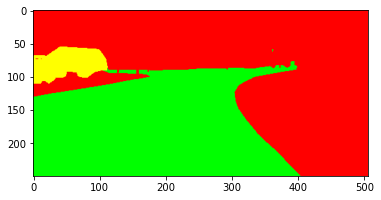

In [5]:
mask=dataSet[2][1]
plt.imshow(dataSet.class_to_rgb(mask).permute(1,2,0))

In [6]:
#https://github.com/jarvislabsai/blog/blob/master/build_resnet34_pytorch/Building%20Resnet%20in%20PyTorch.ipynb
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #in case of size problems implement 0-padding--> https://stackoverflow.com/questions/58307036/is-there-really-no-padding-same-option-for-pytorchs-conv2d
        #pad = nn.ZeroPad2d(conv_padding)
        #out=pad(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [7]:
def _make_layer(block, inplanes,planes, blocks, stride=1):
    downsample = None  
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(            
            nn.Conv2d(inplanes, planes, 1, stride, bias=False),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))
    return nn.Sequential(*layers)

In [34]:
class ResNetEncode_UNetDecode(nn.Module):

    def __init__(self, block, layers, num_classes=4):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.x1=0
        self.x2=0
        self.x3=0
        self.x4=0
        
      
  
        self.maxpoolUnet=nn.MaxPool2d(kernel_size=2, stride=2)
        self.convBottom1=nn.Conv2d(512, 1024, 3, 1,1)
        self.batchBottom1= nn.BatchNorm2d(1024)
        self.convBottom2=nn.Conv2d(1024, 1024, 3, 1,1)
        self.batchBottom2= nn.BatchNorm2d(1024)
                
        #self.up=nn.Conv2d(1024,512,2,1,2)#nn.Upsample(scale_factor=2, mode='nearest')
        self.upConv= nn.Conv2d(1024,512,2,1,(8,16))
            
        #concatenation      
        self.conv1U= nn.Conv2d(1024,512,3,1,1)
        self.batch1= nn.BatchNorm2d(512)  
        self.conv11= nn.Conv2d(512,512,3,1,1)
        self.batch11= nn.BatchNorm2d(512)  
        
        self.upConv2= nn.Conv2d(512,256,2,1,(16,32))        
         #layer 1
        self.conv2 = nn.Conv2d(512, 256, 3, 1,1)
        self.batch2= nn.BatchNorm2d(256)
         #relu
            
        self.conv3 = nn.Conv2d(256, 256, 3, 1,1)
        self.batch3= nn.BatchNorm2d(256)
        self.upConv3= nn.Conv2d(256,128,2,1,(32,64))     
        
         #layer 2   
        self.conv4= nn.Conv2d(256,128,3,1,1)
        self.batch4=nn.BatchNorm2d(128)
        
        self.conv5= nn.Conv2d(128,128,3,1,1)
        self.batch5=nn.BatchNorm2d(128)
        self.upConv4= nn.Conv2d(128,64,2,1,(64,128))     
        #layer 3
        self.conv6= nn.Conv2d(128,64,3,1,1)
        self.batch6=nn.BatchNorm2d(64)
        
        self.conv7= nn.Conv2d(64,64,3,1,1)
        self.batch7=nn.BatchNorm2d(64)
        #layer 4
      
 
        #final convolution
        self.conv8= nn.Conv2d(64,4,3,1,1)#20,3,1)
        #self.batch8=nn.BatchNorm2d(1)#20
            
    def concatenate(self,x1,x2): #https://github.com/milesial/Pytorch-UNet/blob/6aa14cbbc445672d97190fec06d5568a0a004740/unet/unet_parts.py#L42
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        
        addBotXd=0
        addBotYd=0
        if(diffX%2!=0):
          addBotXd=1
        if(diffY%2!=0):
          addBotYd=1
            
       
        addTopX=diffX//2
        addBotX=diffX//2+addBotXd
        addTopY=diffY//2
        addBotY=diffY//2+addBotYd
               
                 #10          #5
        x1 = F.pad(x1,pad= (addTopY,addBotY,addTopX,addBotX)) #19, 
        
        
    
        x = torch.cat([x2, x1], dim=1)
        return x

    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        #downsampling (ResNet Encoder)
        x = self.conv1(x)           
        x = self.bn1(x)
        x = self.relu(x)
                 
        x = self.layer1(x)        
                         
        self.x1=x
        x = self.layer2(x)          
        self.x2=x
     
        x = self.layer3(x)         
        self.x3=x
        
        x = self.layer4(x)          
        self.x4=x
        x=self.maxpoolUnet(x)
        #upsampling (UNet Decoder)
        
        x=self.convBottom1(x)
        x=F.relu(x)
        x=self.batchBottom1(x)
        x=self.convBottom2(x)
        x=F.relu(x)
        x=self.batchBottom2(x)
       
        #x=self.up(x)
        x=self.upConv(x)
        
        x=self.concatenate(x,self.x4)
        
       
        x=self.conv1U(x)
        x=F.relu(x)
        x=self.batch1(x)
        x=self.conv11(x)
        x=F.relu(x)
        x=self.batch11(x)
                
        #x=self.up(x)
        x=self.upConv2(x)
        
        x=self.concatenate(x,self.x3)
        
        x=self.conv2(x)
        x=F.relu(x)
        x=self.batch2(x)
        x=self.conv3(x)
        x=F.relu(x)
        x=self.batch3(x)
        
        
        #x=self.up(x)
        x=self.upConv3(x)
        x=self.concatenate(x,self.x2)
        x=self.conv4(x)
        x=F.relu(x)
        x=self.batch4(x)
        x=self.conv5(x)
        x=F.relu(x)
        x=self.batch5(x)
        
        #x=self.up(x)
        x=self.upConv4(x)
        x=self.concatenate(x,self.x1)
        x=self.conv6(x)
        x=F.relu(x)
        x=self.batch6(x)
        x=self.conv7(x)
        x=F.relu(x)
        x=self.batch7(x)
        x=self.conv8(x)
        
        
        
        return x

In [35]:
#set up Net Architecture
def resnetUNet():
    layers=[3, 4, 6, 3] #ResNet 34 
    model = ResNetEncode_UNetDecode(BasicBlock, layers)
    return model

In [39]:
 # Look up graphic cards
torch.cuda.empty_cache()
device = torch.device('cuda')

#Initalize model
model=resnetUNet().to(device)
#load pre trained ResNet model
#model.load_state_dict(torch.load('model_ResNet34_40Epoch (1).pth'), strict=False)
pretrained_dict = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
model_dict = model.state_dict()
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)

model.eval()


#UNet=UNetDecoder().to(device)
from torchsummary import summary
summary(model, input_size=(3,512, 1024))


Using cache found in /projects/cfcc392c-e211-4346-b376-708130249bf4/.cache/torch/hub/pytorch_vision_v0.9.0


AttributeError: 'ResNet' object has no attribute 'items'

In [11]:
#print(model) https://towardsdatascience.com/everything-you-need-to-know-about-saving-weights-in-pytorch-572651f3f8de
#for name, param in model.named_parameters():
#    print('name: ', name)
#    print(type(param))
#    print(param)
#    print("======")

In [1]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Initialize optimizer

# Initialize learning scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


NameError: name 'optim' is not defined

In [13]:
from livelossplot import PlotLosses #https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb



# Define training loop
def train(model, device, train_loader, optimizer, epoch):
    plotlosses = PlotLosses()
    model.train()
    logs = {}
    epochLoss=[]
    epochAcc=[]
    running_loss = 0.0
    running_corrects = 0
    running_count=0
    for batch_idx, (data, target,labelrgb) in enumerate(train_loader):
        
       
        data, target = data.to(device), target.to(device,dtype=torch.int64)
        
        optimizer.zero_grad()
        output = model(data)

       
        # TK_HERE, we need to check what output is being generated, and what out target is,
        loss = F.cross_entropy(output, target)
        
        running_loss += loss.detach() * data.size(0)
        epochLoss.append(loss)
        _, preds = torch.max(output, 1)
        running_corrects += torch.sum(preds == target.data)
        running_count +=len(target.data)
        
      
        
        acc= running_corrects/running_count
        epochAcc.append(acc)
        
        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
       
    return sum(epochLoss)/len(epochLoss),sum(epochAcc)/len(epochAcc)


In [14]:
from tqdm import tqdm
def Validation(model, device, Val_loader):
    plotlosses = PlotLosses()
    logs = {}
    epochLoss=[]
    epochAcc=[]
    epochClassLoss = {}
    IOU=[]
    running_loss = 0.0
    running_corrects = 0https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    running_count=0
    torch.cuda.empty_cache()
    with torch.no_grad():
   
        net=model
      

        for batch_idx, (data, target,labelrgb) in tqdm(enumerate(Val_loader)):
            
            data, target = data.to(device), target.to(device)    
            output = net(data)
            #collect all IoU scores throughout the dataset & build average after going through all images
            IoUscore=IoU(output, target,Val_loader.dataset)
           
            IOU.append(IoUscore)
            loss = F.cross_entropy(output, target)# Initialize learning scheduler
            running_loss += loss.detach() * data.size(0)
            
            
            epochLoss.append(loss)
            _, preds = torch.max(output, 1)
            running_corrects += torch.sum(preds == target.data)
            running_count +=len(target.data)

            
            targetClassid = target.data # Here
            predictedClassID = preds # here
            
           
            acc= running_corrects/running_count
            epochAcc.append(acc)
            #return averaged loss/accuracy over the validation set

                
            
    return sum(epochLoss)/len(epochLoss),sum(epochAcc)/len(epochAcc), epochClassLoss,sum(IOU)/len(IOU)

#resources
#https://www.jeremyjordan.me/evaluating-image-segmentation-models/
#see https://github.com/milesial/Pytorch-UNet/blob/6aa14cbbc445672d97190fec06d5568a0a004740/train.py
#or https://medium.com/@cyborg.team.nitr/miou-calculation-4875f918f4cb
def IoU(prediction,target, dataset):
    target=target.cpu()
    prediction=prediction.cpu()
   
    targetN=torch.zeros((2,3,250,506))
    maskN=torch.zeros(2,3,250,506)
    targetN[0]= dataset.class_to_rgb(target[0])#colorize mask to be able to compare 
    targetN[1]= dataset.class_to_rgb(target[1])
    
    mask=processPred(prediction)
    
    maskN[0]= dataset.class_to_rgb(torch.squeeze(mask[0],0))
    maskN[1]= dataset.class_to_rgb(torch.squeeze(mask[1],0))
    
    
    intersection = np.logical_and(targetN,maskN).numpy() #map differences of prediction and target
    union = np.logical_or(targetN, maskN).numpy()        #map similiarities of prediction and target
    iou_score = (np.sum(intersection) / np.sum(union))*100
    
    return iou_score

def processPred(mask):
   
     #mapping of the 4 used classes to 1 mask to calculate IoU score
     mask0=np.where(mask[0][0]==True,0,0)   
     mask1=np.where(mask[0][1]==True,2,0)
     mask2=np.where(mask[0][2]==True,3,0)
     mask3=np.where(mask[0][3]==True,4,0)   
     a=mask0|mask1|mask2|mask3
    
     mask01=np.where(mask[1][0]==True,0,0)   
     mask11=np.where(mask[1][1]==True,2,0)
     mask21=np.where(mask[1][2]==True,3,0)
     mask31=np.where(mask[1][3]==True,4,0)   
     b=mask01|mask11|mask21|mask31
     
   
     #give masks coloring and stack them on top of each other to get shape of 1 batch (consisting of 2 Label files)         
     Mask1 =torchvision.transforms.functional.to_tensor(a)
     Mask2 =torchvision.transforms.functional.to_tensor(b)
    
     return torch.stack((Mask1,Mask2))

SyntaxError: invalid syntax (<ipython-input-14-af90b19fb5ad>, line 10)

In [0]:
#lossV, accV, epochClassLoss, IoUscore =Validation(model,device, Val_dataLoader)


In [0]:
# Define test loop
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
def saveModel(model,path):
    torch.save(model.state_dict(), path) 
    
import copy

from livelossplot import PlotLosses 
plotlosses = PlotLosses()
torch.cuda.empty_cache()
logs = {}
#best_model_wts = copy.deepcopy(model.state_dict())
#best_acc = 0.0
BestIoU=0
BestModel=model
for epoch in range(1, 25): #40):
    loss,acc=train(model, device, trainDataLoader, optimizer, epoch)
    lossV, accV, epochClassLoss, IoUscore =Validation(model,device, Val_dataLoader)
    if IoUscore>BestIoU:
        BestIoU=IoUscore
        BestModel=model
    
    prefix=''
   
    
    logs[prefix + 'log loss'] = loss
    #logs[prefix + 'acc']=acc
    prefix='val_'
    logs[prefix + 'log loss'] = lossV
    logs[prefix + 'IoU']=IoUscore
    plotlosses.update(logs)
    plotlosses.send()
    #test(model, device, test_dataLoader)
    scheduler.step()

 
path1="/projects/cfcc392c-e211-4346-b376-708130249bf4/bestPerformance2_model_UNet.pth"  
path2="/projects/cfcc392c-e211-4346-b376-708130249bf4/last_model2_UNet.pth"  
saveModel(BestModel,path1)   
saveModel(model,path2)

In [0]:
#see https://github.com/milesial/Pytorch-UNet/blob/6aa14cbbc445672d97190fec06d5568a0a004740/predict.py
def predict(image,model):
     out_threshold=0.5
     img = image.unsqueeze(0) ##add a dimension [1,3,512,1024] to simulate dataloader(batch size)
     img = img.to(device=device, dtype=torch.float32)   
    
     
     with torch.no_grad():
         pred=model(img)
         probs = F.softmax(pred, dim=1)
         probs = probs.squeeze(0)
         tf = transforms.Compose(
                    [
                        transforms.ToPILImage(),
                        transforms.Resize(size=(250, 506), interpolation=Image.NEAREST),
                        transforms.ToTensor()
                    ]
                )
         
         probs = tf(probs.cpu())
         
         full_mask = probs.squeeze().cpu().numpy()
         return full_mask > out_threshold

In [0]:

mask=dataSet.class_to_rgb(dataSet[1][1])
orgmask=mask



predmask,gtmask=maskDecoder(predict(dataSet[1][0],model),dataSet)
intersection = np.logical_and(predmask,orgmask).numpy() #map differences of prediction and target
union = np.logical_or(predmask,orgmask).numpy()        #map similiarities of prediction and target
iou_score = (np.sum(intersection) / np.sum(union))*100

In [0]:
print(iou_score)


In [0]:
def LoadModel(modeltype):
    Path=''
    if modeltype=='best':
        Path="/projects/cfcc392c-e211-4346-b376-708130249bf4/bestPerformance_model_UNet.pth"
    else:
        Path="/projects/cfcc392c-e211-4346-b376-708130249bf4/last_model_UNet.pth"
    model =resnetUNet().to(device)    
    model.load_state_dict(torch.load(Path))
    model.eval()
    return model    

In [0]:
def maskDecoder(mask,dataset):

    mask0=np.where(mask[0]==True,0,0)   
    mask1=np.where(mask[1]==True,1,0)
    mask2=np.where(mask[2]==True,2,0)
    mask3=np.where(mask[3]==True,3,0)   
    a=mask0|mask1|mask2|mask3
    RGB_colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]]  #0=unlabled(red) #1=road(green) 2=sky(blue)3=car(yellow)
    a1=np.zeros((3,250,506))
    b=np.zeros((3,250,506))
    c=np.zeros((3,250,506))
    d=np.zeros((3,250,506))
    a1[0]=np.where(a==0,RGB_colors[0][0],[0]) # dont consider a[1] a[2] because the color values from the first color(RGB_colors[0]) are 0
    b[1]=np.where(a==0,RGB_colors[1][1],[0])
    c[2]=np.where(a==0,RGB_colors[2][2],[0])
    d[0]=np.where(a==0,RGB_colors[3][0],[0])
    
   
    imgGroundTruth=a1+b+c+d#a1|b|c|d
             
    
    imagecolored = dataSet.class_to_rgb(a)

    return imagecolored,imgGroundTruth

test=dataSet[1][0]
predictionMask,groundTruthMask,=maskDecoder(predict(test,model),dataSet)
groundTruthMask=np.transpose(groundTruthMask,(1,2,0))

fig, axs = plt.subplots(3)

axs[0].imshow(predictionMask.permute(1,2,0))
axs[1].imshow((groundTruthMask))
axs[2].imshow(test.permute(1,2,0))

In [0]:
#select uploaded image and let the model predict the masks
PathImg='IMG-20191025-WA0017.jpg'
tf = transforms.Compose([  transforms.ToPILImage(),
                                    transforms.Resize(size=(512, 1024), interpolation=Image.BILINEAR),
                                    transforms.ToTensor()
                                 ])
loadedModel=LoadModel('last')
image =tf(plt.imread(PathImg))
predictionMask,groundTruthMask,=maskDecoder(predict(image,loadedModel))
groundTruthMask=np.transpose(groundTruthMask,(1,2,0))

fig, axs = plt.subplots(3)
axs[0].imshow(image.permute(1,2,0))
axs[1].imshow(predictionMask)
axs[2].imshow((groundTruthMask))





